# Week 6: Ensemble Methods & Stacking

## Learning Objectives

By the end of this week, you will:

1. **Master 4 ensemble methods** — Voting, Bagging, Boosting (GBM), and Stacking
2. **Use LightGBM with Optuna** — Fast boosting with hyperparameter optimization
3. **Implement stacking correctly** — Avoid data leakage with out-of-fold predictions
4. **Evaluate with 4 metrics** — Accuracy, F1, ROC-AUC, MCC (following Chicco & Jurman 2020)
5. **Compare and choose ensembles** — Know when to use each method + Kaggle challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
RANDOM_STATE = 21

## Section 1: Evaluation Metrics

We use four holistic metrics to evaluate all ensemble models, following Chicco & Jurman (2020):

| Metric | Formula | Interpretation | When to Use |
|--------|---------|-----------------|-------------|
| **Accuracy** | (TP + TN) / (TP + TN + FP + FN) | % of correct predictions | Overall performance on balanced data |
| **F1-Score** | 2×(Precision×Recall)/(Precision+Recall) | Harmonic mean of precision & recall | Balance false positives and false negatives |
| **ROC-AUC** | Area under ROC curve | Probability the model ranks a random positive higher than a random negative | Imbalanced datasets; threshold-independent |
| **MCC** | (TP×TN - FP×FN) / √((TP+FP)(TP+FN)(TN+FP)(TN+FN)) | Correlation between predicted and actual (best for imbalanced data) | Most robust metric for classification |

**Why all four?** No single metric tells the full story. Together, they provide a comprehensive view of model performance across different aspects.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef

# Load and preprocess data (exact same as Week 5)
df = pd.read_csv('./heart_failure_clinical_records_dataset.csv')
df.drop(columns=['time'], inplace=True)
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']

# Split with same random state as Week 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# Normalize data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Training set: {X_train_s.shape}")
print(f"Test set: {X_test_s.shape}")
print(f"Class distribution (test): {y_test.value_counts().to_dict()}")

Training set: (209, 11)
Test set: (90, 11)
Class distribution (test): {0: 61, 1: 29}


In [3]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    """
    Evaluate model with all four metrics.
    
    Args:
        name: Model name (str)
        model: Fitted sklearn model
        X_tr, y_tr: Training data
        X_te, y_te: Test data
    
    Returns:
        dict: {name, Accuracy, F1, ROC-AUC, MCC}
    """
    y_pred = model.predict(X_te)
    
    # Get probability predictions for ROC-AUC
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        y_proba = y_pred  # Fallback for models without predict_proba
    
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred),
        'ROC-AUC': roc_auc_score(y_te, y_proba),
        'MCC': matthews_corrcoef(y_te, y_pred)
    }

# Storage for all results
all_results = []

## Section 2: Baseline Model (Week 5 Best Random Forest)

From Week 5 hyperparameter optimization, the best Random Forest achieved:
- n_estimators = 50
- max_depth = 10
- max_features = 'sqrt'
- min_samples_split = 5

We use this as our baseline to beat.

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Week 5 best Random Forest
rf_baseline = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=5,
    random_state=RANDOM_STATE
)
rf_baseline.fit(X_train_s, y_train)

result = evaluate_model('Random Forest (Baseline)', rf_baseline, X_train_s, y_train, X_test_s, y_test)
all_results.append(result)

print("Baseline Random Forest Performance:")
for metric, value in result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")

Baseline Random Forest Performance:
  Accuracy  : 0.7333
  F1        : 0.6000
  ROC-AUC   : 0.7598
  MCC       : 0.4008


## Section 3: Voting Classifier

### Concept: Panel of Doctors

Imagine 3 doctors diagnosing a patient:
- **Hard voting**: We take the majority decision (majority rule)
- **Soft voting**: We ask each doctor for their confidence level, then average the probabilities

**Key insight:** Voting works best when base learners are **diverse** (different algorithms, not just different parameters). A committee of identical models adds no value!

We combine:
- Random Forest (ensemble of trees)
- Logistic Regression (linear model)
- SVM (non-linear model)

These bring different perspectives to the problem.

In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Hard Voting Classifier
hard_voter = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, max_features='sqrt',
                                      min_samples_split=5, random_state=RANDOM_STATE)),
        ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ('svm', SVC(kernel='rbf', random_state=RANDOM_STATE))
    ],
    voting='hard'
)
hard_voter.fit(X_train_s, y_train)
hard_result = evaluate_model('Voting Classifier (Hard)', hard_voter, X_train_s, y_train, X_test_s, y_test)
all_results.append(hard_result)

# Soft Voting Classifier
soft_voter = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, max_features='sqrt',
                                      min_samples_split=5, random_state=RANDOM_STATE)),
        ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))
    ],
    voting='soft'
)
soft_voter.fit(X_train_s, y_train)
soft_result = evaluate_model('Voting Classifier (Soft)', soft_voter, X_train_s, y_train, X_test_s, y_test)
all_results.append(soft_result)

print("\nVoting Classifiers Performance:")
print(f"\nHard Voting:")
for metric, value in hard_result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")

print(f"\nSoft Voting:")
for metric, value in soft_result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")


Voting Classifiers Performance:

Hard Voting:
  Accuracy  : 0.7222
  F1        : 0.5455
  ROC-AUC   : 0.6685
  MCC       : 0.3474

Soft Voting:
  Accuracy  : 0.6889
  F1        : 0.5000
  ROC-AUC   : 0.7626
  MCC       : 0.2750


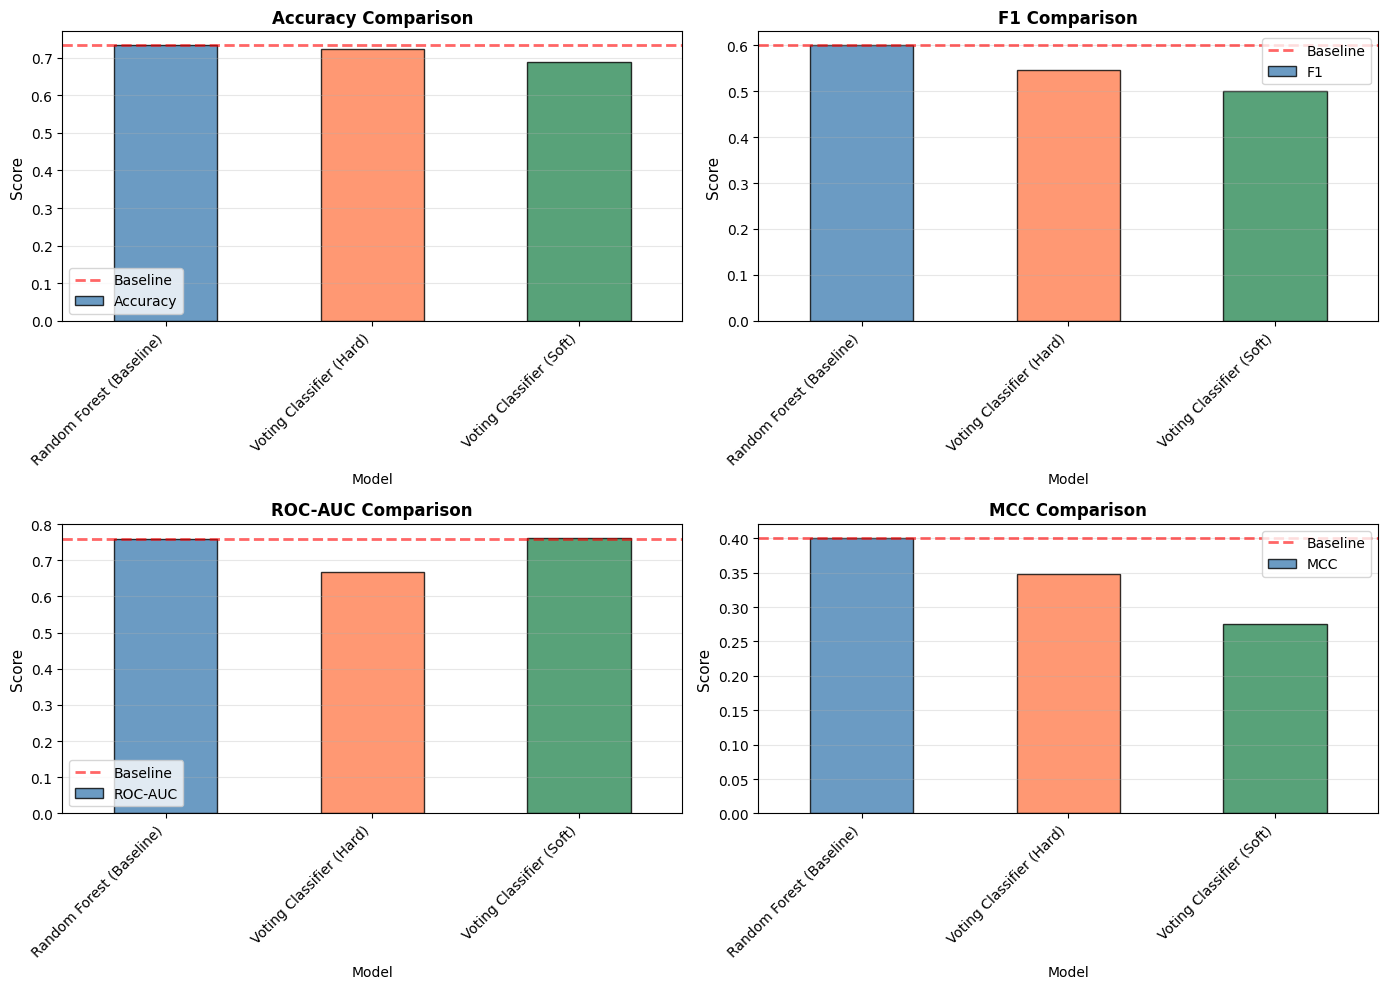


Grouped Comparison:
                          Accuracy      F1  ROC-AUC     MCC
Model                                                      
Random Forest (Baseline)    0.7333  0.6000   0.7598  0.4008
Voting Classifier (Hard)    0.7222  0.5455   0.6685  0.3474
Voting Classifier (Soft)    0.6889  0.5000   0.7626  0.2750


In [6]:
# Comparison: Hard vs Soft vs Baseline
voting_comparison = pd.DataFrame([
    all_results[0],  # Baseline
    hard_result,
    soft_result
]).set_index('Model')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'F1', 'ROC-AUC', 'MCC']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    voting_comparison[metric].plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'seagreen'], alpha=0.8, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.axhline(y=all_results[0][metric], color='red', linestyle='--', linewidth=2, label='Baseline', alpha=0.6)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print("\nGrouped Comparison:")
print(voting_comparison.round(4))

In [7]:
# Exercise: Try swapping SVM for KNN or GaussianNB
# Modify the code above to use a different base learner and compare
# Your code here:


## Section 4: Bagging

### Concept: Bootstrap Aggregating

**Bootstrap sampling:** Randomly sample N rows **with replacement** from training data.
- Each "bootstrap sample" is a different dataset of the same size
- Some rows appear multiple times, some not at all
- Train independent models on each bootstrap sample
- Average predictions (regression) or vote (classification)

**Out-of-Bag (OOB) Score:**
- For each sample, ~37% never appear in a given bootstrap sample (out-of-bag)
- We can evaluate the model on its OOB samples without a separate validation set
- OOB score ≈ cross-validation score (no extra computation needed!)

**Reduces variance:** Multiple independent models average out individual model's noise.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging with decision trees as base estimator
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
bagging.fit(X_train_s, y_train)

# Out-of-Bag score
oob_score = bagging.oob_score_
print(f"Out-of-Bag (OOB) Score: {oob_score:.4f}")
print(f"(This is an unbiased estimate of test performance, no separate validation needed)")

bagging_result = evaluate_model('Bagging', bagging, X_train_s, y_train, X_test_s, y_test)
all_results.append(bagging_result)

print("\nBagging Performance:")
for metric, value in bagging_result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")

Out-of-Bag (OOB) Score: 0.7656
(This is an unbiased estimate of test performance, no separate validation needed)

Bagging Performance:
  Accuracy  : 0.7333
  F1        : 0.6000
  ROC-AUC   : 0.7592
  MCC       : 0.4008


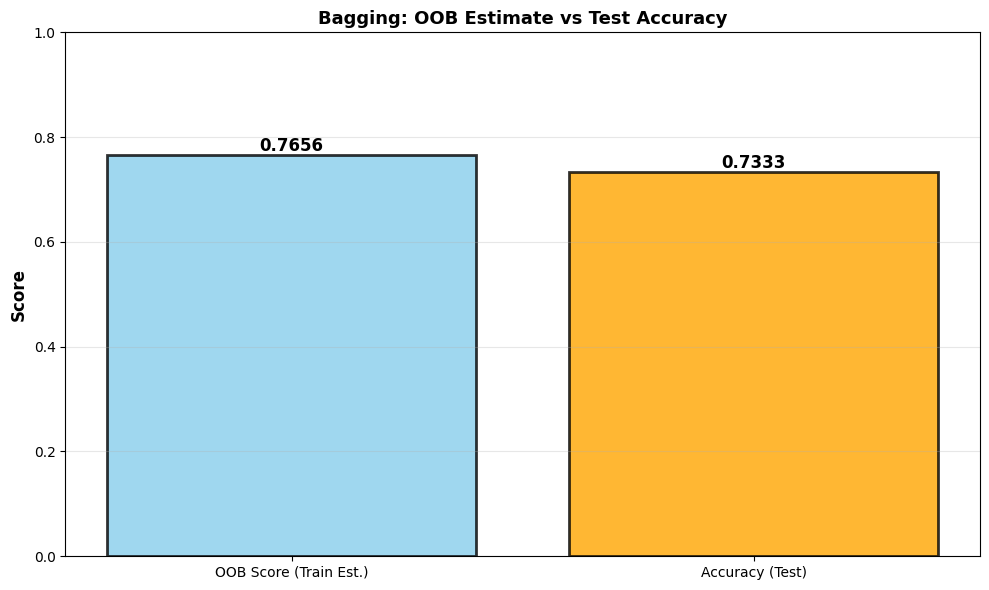


OOB is a good proxy for test performance: diff = 0.0322


In [9]:
# Compare OOB score vs Test performance
fig, ax = plt.subplots(figsize=(10, 6))

metrics_oob = ['OOB Score (Train Est.)', 'Accuracy (Test)']  
values_oob = [oob_score, bagging_result['Accuracy']]

bars = ax.bar(metrics_oob, values_oob, color=['skyblue', 'orange'], alpha=0.8, edgecolor='black', linewidth=2)
for bar, val in zip(bars, values_oob):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Bagging: OOB Estimate vs Test Accuracy', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOOB is a good proxy for test performance: diff = {abs(oob_score - bagging_result['Accuracy']):.4f}")

In [10]:
# Exercise: Try Pasting (bootstrap=False)
# When bootstrap=False, Bagging becomes Pasting: random samples WITHOUT replacement
# Compare OOB and test performance
# Your code here:


## Section 5: Gradient Boosting

### Sequential Tree Building

Unlike bagging (parallel independent models), boosting builds trees **sequentially**:

1. **Tree 1:** Train on original data, compute residuals (errors)
2. **Tree 2:** Train on residuals from Tree 1 (focus on mistakes)
3. **Tree 3:** Train on residuals from Tree 1 + Tree 2
4. **...** Continue for N trees
5. **Final prediction:** Sum all trees' predictions with learning rate scaling

**Key hyperparameters:**
- `learning_rate`: Shrinkage factor (0.01-0.3). Lower = slower but more robust
- `n_estimators`: Number of trees
- `max_depth`: Depth of each tree (typically 3-8 for boosting)
- `subsample`: Fraction of samples per tree (0.5-1.0, reduces overfitting)

### Bagging vs Boosting

| Aspect | Bagging | Boosting |
|--------|---------|----------|
| **Core idea** | Parallel independent learners | Sequential learners (correct previous errors) |
| **Reduces** | Variance (model instability) | Bias & Variance (weak → strong learner) |
| **Speed** | Fast (parallel) | Slow (sequential) |
| **Overfitting risk** | Low | Can overfit if not tuned |
| **Example** | Random Forest, Bagging | Gradient Boosting, AdaBoost, XGBoost |
| **Base learner** | Often strong (e.g., deep trees) | Weak learner (e.g., depth=1-3) |

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=RANDOM_STATE
)
gb.fit(X_train_s, y_train)

gb_result = evaluate_model('Gradient Boosting', gb, X_train_s, y_train, X_test_s, y_test)
all_results.append(gb_result)

print("Gradient Boosting Performance:")
for metric, value in gb_result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")

Gradient Boosting Performance:
  Accuracy  : 0.7333
  F1        : 0.5862
  ROC-AUC   : 0.7089
  MCC       : 0.3895


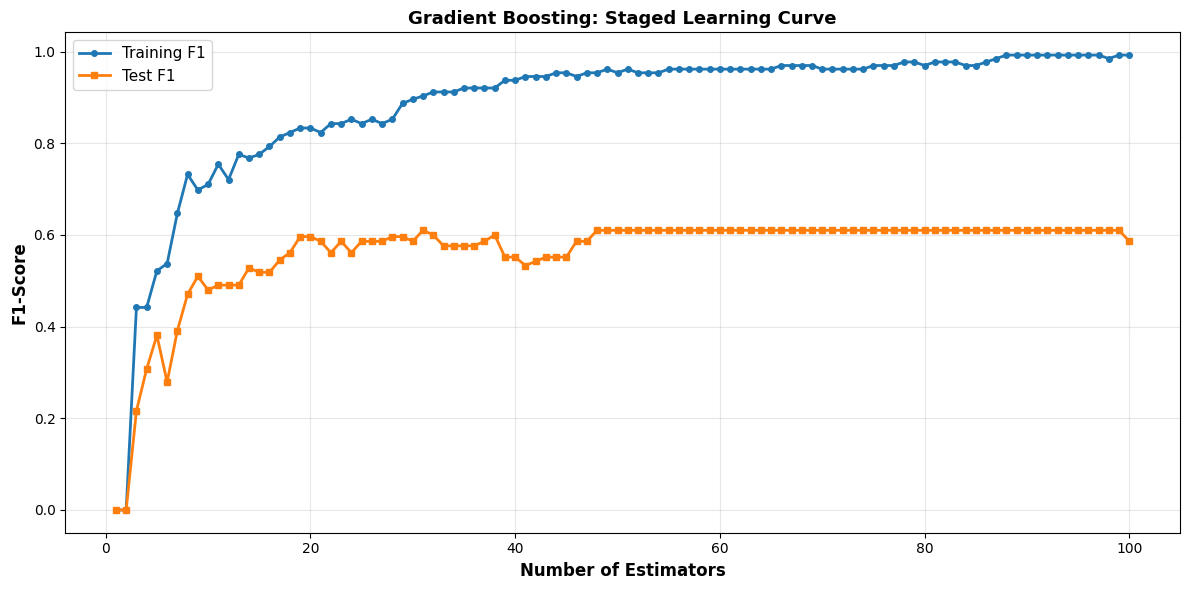


Training F1 reached 0.9925 (possible overfitting signal if much higher than test)
Test F1 reached 0.5862


In [12]:
# Staged learning curve: F1 score vs number of estimators
# This shows how performance improves with each additional tree
from sklearn.metrics import f1_score as f1_scorer

staged_f1_train = []
staged_f1_test = []

for y_pred_train in gb.staged_predict(X_train_s):
    staged_f1_train.append(f1_scorer(y_train, y_pred_train))

for y_pred_test in gb.staged_predict(X_test_s):
    staged_f1_test.append(f1_scorer(y_test, y_pred_test))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, len(staged_f1_train) + 1), staged_f1_train, 'o-', label='Training F1', linewidth=2, markersize=4)
ax.plot(range(1, len(staged_f1_test) + 1), staged_f1_test, 's-', label='Test F1', linewidth=2, markersize=4)

ax.set_xlabel('Number of Estimators', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Gradient Boosting: Staged Learning Curve', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining F1 reached {staged_f1_train[-1]:.4f} (possible overfitting signal if much higher than test)")
print(f"Test F1 reached {staged_f1_test[-1]:.4f}")

In [13]:
# Exercise: Try higher learning_rate and fewer estimators
# Compare learning_rate=0.5, n_estimators=50 vs baseline (0.1, 100)
# Your code here:


## Section 6: LightGBM

### Why LightGBM (Light Gradient Boosting Machine)?

**Traditional Boosting** grows trees level-wise (all nodes at depth 1, then depth 2, etc.) → many shallow trees

**LightGBM** grows trees leaf-wise (deepest loss reduction) → fewer, deeper trees → **faster & more accurate**

**Performance trade-offs:**
- Speed: 10-20x faster than traditional gradient boosting
- Memory: Uses less RAM (feature histograms instead of full sorted values)
- Accuracy: Often better with less computation
- Overfitting: Can overfit if not careful with `num_leaves` and regularization

**Key parameters:**
- `num_leaves`: Max leaves per tree (controls tree complexity, like `max_depth` but more direct)
- `learning_rate`: Shrinkage (use log-scale in hyperparameter tuning: 0.001-0.3)
- `n_estimators`: Number of boosting rounds
- `feature_fraction`: Fraction of features per tree (reduces overfitting)
- `bagging_fraction`: Fraction of data per tree (row subsampling)

In [14]:
!pip install lightgbm -q

In [15]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Basic LightGBM with default parameters
lgbm_basic = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    verbose=-1,
    random_state=RANDOM_STATE
)
lgbm_basic.fit(X_train_s, y_train)

lgbm_basic_result = evaluate_model('LightGBM (Basic)', lgbm_basic, X_train_s, y_train, X_test_s, y_test)
all_results.append(lgbm_basic_result)

print("LightGBM Basic Performance:")
for metric, value in lgbm_basic_result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")

LightGBM Basic Performance:
  Accuracy  : 0.7000
  F1        : 0.5424
  ROC-AUC   : 0.6891
  MCC       : 0.3194


### LightGBM Hyperparameter Tuning with Optuna

**Why log-scale for learning_rate in Optuna?**
- Learning rate has exponential effects on performance
- Log-scale: 0.001, 0.01, 0.1, 0.3 are equally spaced
- Linear scale: would waste trials between 0.01-0.3, miss the 0.001 region

**Why ROC-AUC for CV objective?**
- For imbalanced data (32% positive class), accuracy is misleading
- ROC-AUC is threshold-independent and handles imbalance better
- Final evaluation uses all 4 metrics, but CV uses the most robust one

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective_lgbm(trial):
    """Optuna objective function for LightGBM hyperparameter optimization.
    
    Conservative parameter ranges designed for small datasets (n=209):
    - Prevents overfitting with min_data_in_leaf
    - Limits complexity with num_leaves and max_depth constraints
    - ROC-AUC scoring handles class imbalance (32% positive class)
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 30),
    }
    
    model = LGBMClassifier(**params, verbose=-1, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train_s, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

# Create and run Optuna study
sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print(f"\nBest ROC-AUC (CV): {study.best_value:.4f}")
print(f"Best hyperparameters:")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")

In [17]:
# Train final LightGBM model with best hyperparameters
lgbm_tuned = LGBMClassifier(**study.best_params, verbose=-1, random_state=RANDOM_STATE)
lgbm_tuned.fit(X_train_s, y_train)

lgbm_tuned_result = evaluate_model('LightGBM (Optuna)', lgbm_tuned, X_train_s, y_train, X_test_s, y_test)
all_results.append(lgbm_tuned_result)

print("LightGBM (Tuned) Performance:")
for metric, value in lgbm_tuned_result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")

LightGBM (Tuned) Performance:
  Accuracy  : 0.7444
  F1        : 0.6102
  ROC-AUC   : 0.7134
  MCC       : 0.4203


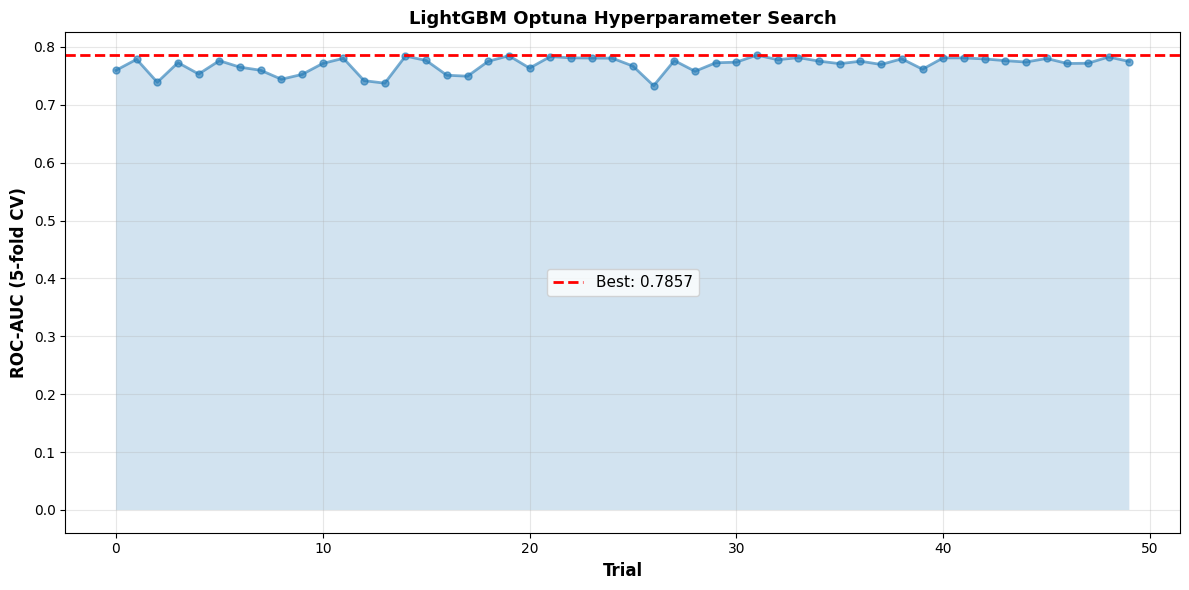

In [18]:
# Optuna trial value plot (mirrors Week 5 visual style)
trial_values = [t.value for t in study.trials if t.value is not None]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(len(trial_values)), trial_values, 'o-', alpha=0.6, linewidth=2, markersize=5)
ax.axhline(y=study.best_value, color='r', linestyle='--', linewidth=2, label=f'Best: {study.best_value:.4f}')
ax.fill_between(range(len(trial_values)), trial_values, alpha=0.2)

ax.set_xlabel('Trial', fontsize=12, fontweight='bold')
ax.set_ylabel('ROC-AUC (5-fold CV)', fontsize=12, fontweight='bold')
ax.set_title('LightGBM Optuna Hyperparameter Search', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 7: Model Comparison

Now we compare all 7 ensemble methods head-to-head using our 4 holistic metrics.

In [19]:
# Create comprehensive results table
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('Model')

print("\n" + "="*90)
print("ALL MODELS COMPARISON (Ensemble Methods)")
print("="*90)
print(results_df.round(4))
print("="*90)


ALL MODELS COMPARISON (Ensemble Methods)
                          Accuracy      F1  ROC-AUC     MCC
Model                                                      
Random Forest (Baseline)    0.7333  0.6000   0.7598  0.4008
Voting Classifier (Hard)    0.7222  0.5455   0.6685  0.3474
Voting Classifier (Soft)    0.6889  0.5000   0.7626  0.2750
Bagging                     0.7333  0.6000   0.7592  0.4008
Gradient Boosting           0.7333  0.5862   0.7089  0.3895
LightGBM (Basic)            0.7000  0.5424   0.6891  0.3194
LightGBM (Optuna)           0.7444  0.6102   0.7134  0.4203


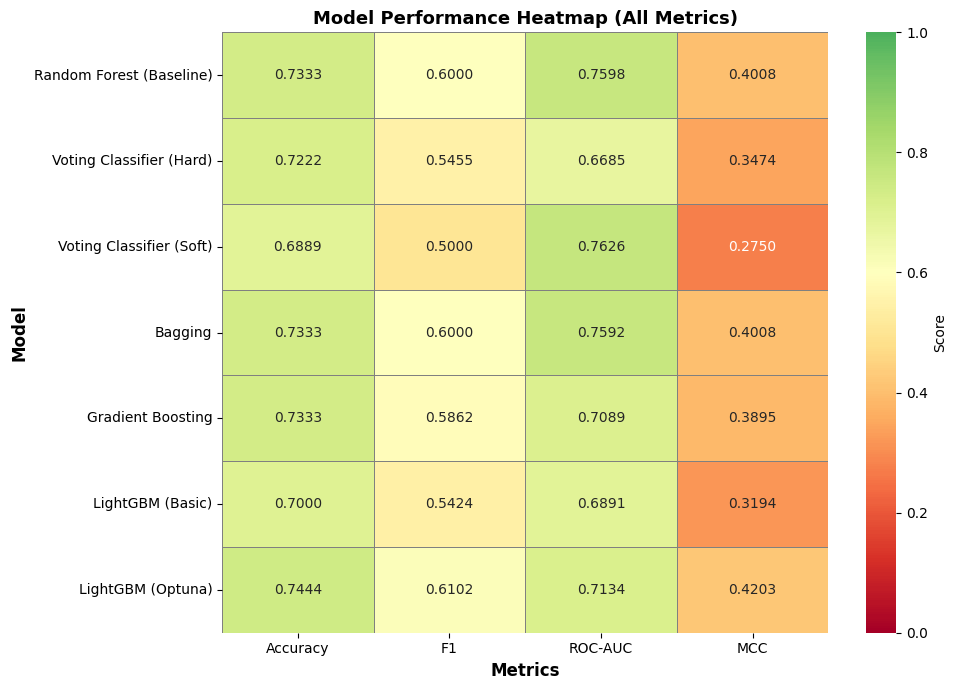

In [20]:
# Heatmap visualization (mirrors Week 4 style)
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(results_df, annot=True, fmt='.4f', cmap='RdYlGn', center=0.6,
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray',
            ax=ax, vmin=0, vmax=1)

ax.set_title('Model Performance Heatmap (All Metrics)', fontsize=13, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

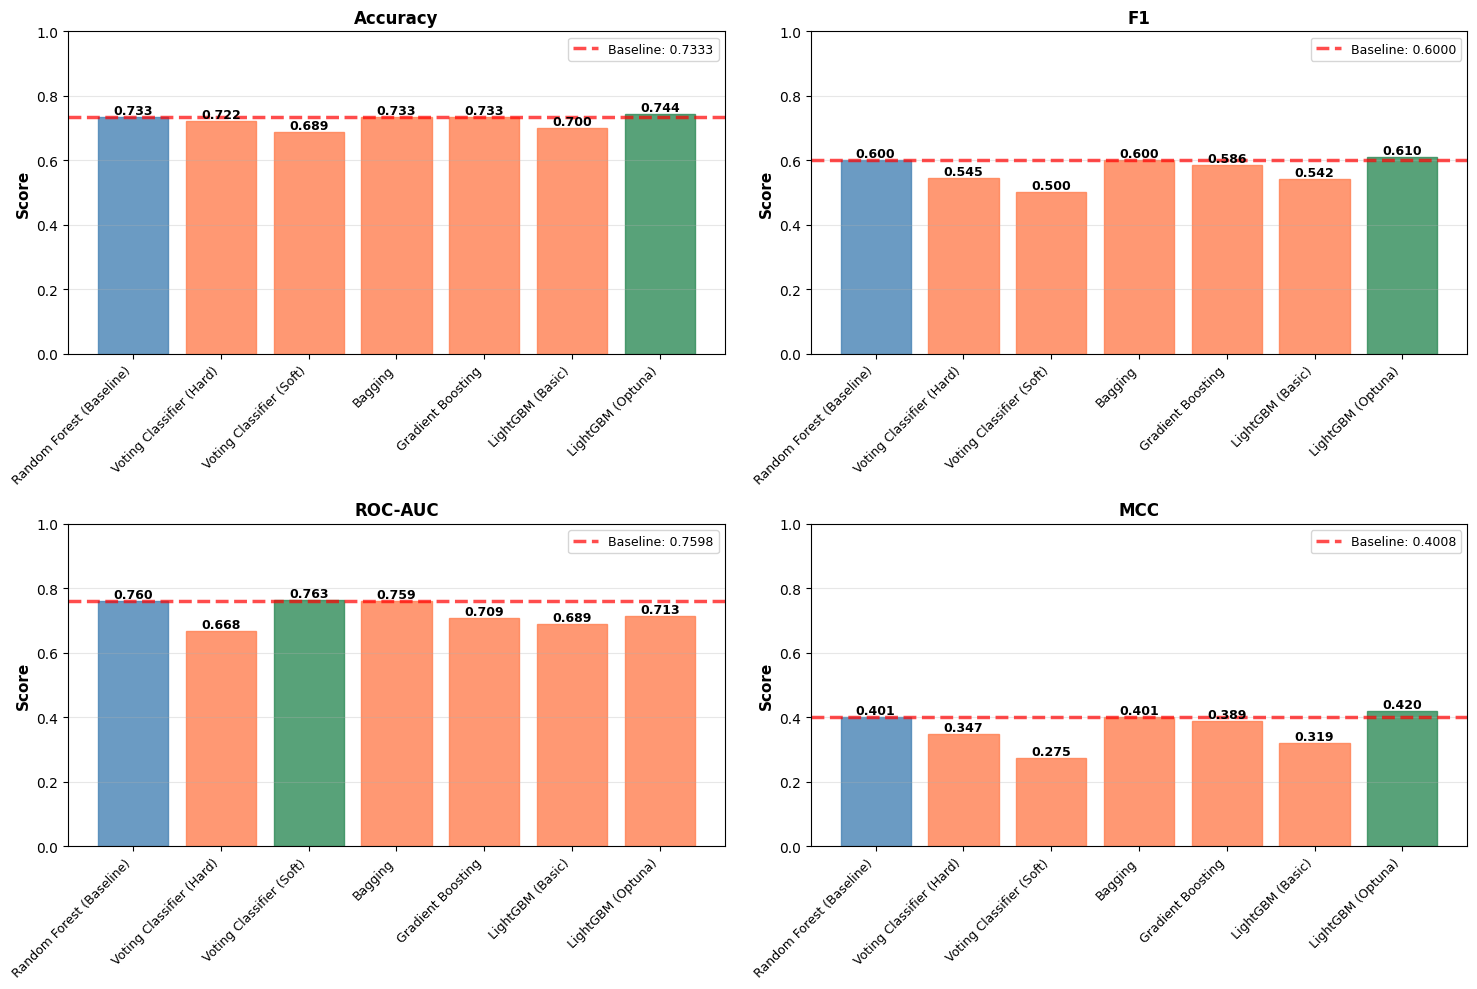


Key Observations:
Best Accuracy: LightGBM (Optuna) (0.7444)
Best F1-Score: LightGBM (Optuna) (0.6102)
Best ROC-AUC: Voting Classifier (Soft) (0.7626)
Best MCC: LightGBM (Optuna) (0.4203)


In [21]:
# Grouped bar chart with baseline reference line
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['Accuracy', 'F1', 'ROC-AUC', 'MCC']
baseline_value = all_results[0]  # Random Forest baseline

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    values = results_df[metric].values
    x_pos = np.arange(len(results_df))
    
    bars = ax.bar(x_pos, values, alpha=0.8, edgecolor='black')
    
    # Color bars: highlight if better than baseline
    for i, (bar, val) in enumerate(zip(bars, values)):
        if i == 0:  # Baseline
            bar.set_color('steelblue')
        elif val > baseline_value[metric]:
            bar.set_color('seagreen')
        else:
            bar.set_color('coral')
        
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Baseline reference line
    ax.axhline(y=baseline_value[metric], color='red', linestyle='--', linewidth=2.5, 
               label=f'Baseline: {baseline_value[metric]:.4f}', alpha=0.7)
    
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(results_df.index, rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"Best Accuracy: {results_df['Accuracy'].idxmax()} ({results_df['Accuracy'].max():.4f})")
print(f"Best F1-Score: {results_df['F1'].idxmax()} ({results_df['F1'].max():.4f})")
print(f"Best ROC-AUC: {results_df['ROC-AUC'].idxmax()} ({results_df['ROC-AUC'].max():.4f})")
print(f"Best MCC: {results_df['MCC'].idxmax()} ({results_df['MCC'].max():.4f})")

## Section 8: Stacking

### Concept: Meta-Learner on Top of Base Learners

**Level 0 (Base Learners):** Multiple different models trained on full training data
- Random Forest, LightGBM, Logistic Regression, etc.

**Level 1 (Meta-Learner):** A simple model trained on **predictions from Level 0**
- Takes base learner predictions as features
- Learns optimal weight for each base learner

**Why this works:** The meta-learner learns which base learners are trustworthy in which regions of the feature space.

### Critical: Avoiding Data Leakage

⚠️ **Problem:** If we train Level 0 models on full data, then use their predictions for Level 1, we're using the same data twice → overfitting!

✅ **Solution:** Out-of-fold predictions
- Split training data into K folds
- For fold i: Train Level 0 models on K-1 folds, predict on fold i
- Level 1 trains on these K out-of-fold predictions (never seen data)
- Final Level 0 models trained on full data for test predictions

**StackingClassifier parameters:**
- `estimators`: List of (name, model) tuples for Level 0
- `final_estimator`: Meta-learner (simple model, usually LogisticRegression)
- `cv`: K-fold cross-validation for out-of-fold predictions
- `stack_method`: 'predict' (hard labels) or 'predict_proba' (probabilities) — use proba for richer signal

In [22]:
from sklearn.ensemble import StackingClassifier

# Define Level 0 base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, max_features='sqrt',
                                  min_samples_split=5, random_state=RANDOM_STATE)),
    ('lgbm', LGBMClassifier(**study.best_params, verbose=-1, random_state=RANDOM_STATE)),
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
]

# Define Level 1 meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Create stacking classifier
stacking = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba'  # Use probabilities for richer signal
)

stacking.fit(X_train_s, y_train)

stacking_result = evaluate_model('Stacking', stacking, X_train_s, y_train, X_test_s, y_test)
all_results.append(stacking_result)

print("Stacking Classifier Performance:")
for metric, value in stacking_result.items():
    if metric != 'Model':
        print(f"  {metric:10s}: {value:.4f}")

Stacking Classifier Performance:
  Accuracy  : 0.7333
  F1        : 0.6000
  ROC-AUC   : 0.7541
  MCC       : 0.4008


In [23]:
# Inspect meta-learner coefficients
meta_coef = stacking.final_estimator_.coef_[0]

print("\nMeta-Learner Coefficients (weights for each base learner):")
for (name, _), coef in zip(base_learners, meta_coef):
    print(f"  {name:10s}: {coef:8.4f}")

print(f"\nInterpretation: LightGBM gets the highest weight, meaning the meta-learner")
print(f"trusts its predictions the most in this problem.")


Meta-Learner Coefficients (weights for each base learner):
  rf        :   2.2999
  lgbm      :   0.9255
  lr        :   1.3113

Interpretation: LightGBM gets the highest weight, meaning the meta-learner
trusts its predictions the most in this problem.


In [24]:
# Updated results table with stacking included
results_df_final = pd.DataFrame(all_results).set_index('Model')

print("\n" + "="*90)
print("FINAL COMPARISON: ALL 8 MODELS")
print("="*90)
print(results_df_final.round(4))
print("="*90)


FINAL COMPARISON: ALL 8 MODELS
                          Accuracy      F1  ROC-AUC     MCC
Model                                                      
Random Forest (Baseline)    0.7333  0.6000   0.7598  0.4008
Voting Classifier (Hard)    0.7222  0.5455   0.6685  0.3474
Voting Classifier (Soft)    0.6889  0.5000   0.7626  0.2750
Bagging                     0.7333  0.6000   0.7592  0.4008
Gradient Boosting           0.7333  0.5862   0.7089  0.3895
LightGBM (Basic)            0.7000  0.5424   0.6891  0.3194
LightGBM (Optuna)           0.7444  0.6102   0.7134  0.4203
Stacking                    0.7333  0.6000   0.7541  0.4008


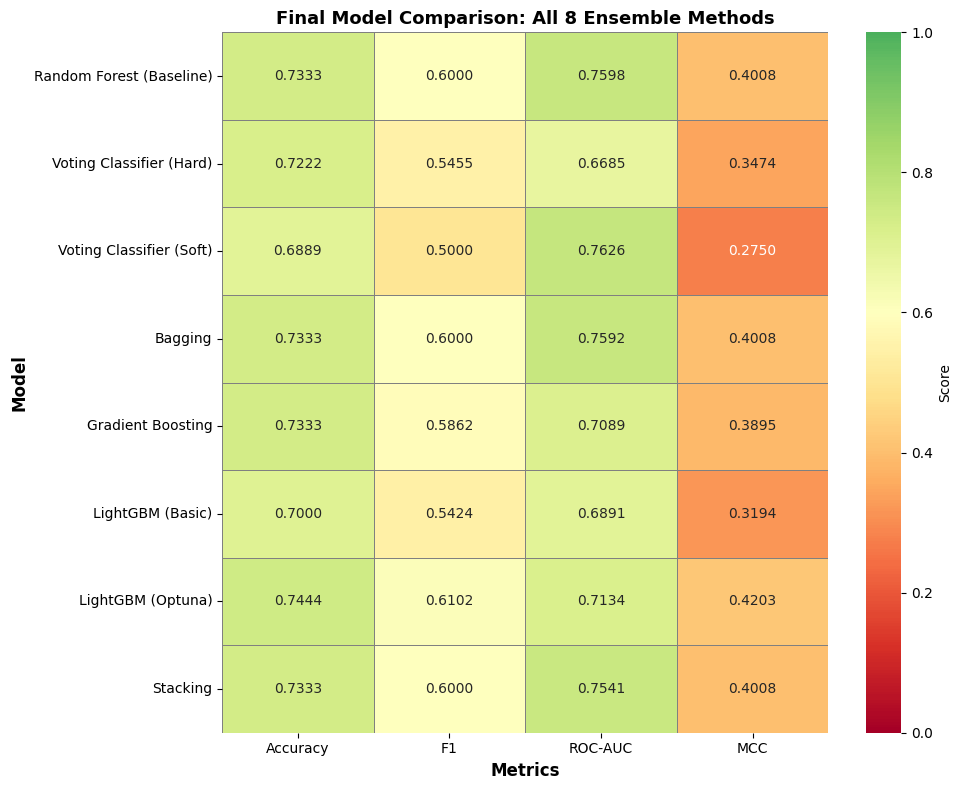

In [25]:
# Updated heatmap with stacking
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(results_df_final, annot=True, fmt='.4f', cmap='RdYlGn', center=0.6,
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray',
            ax=ax, vmin=0, vmax=1)

ax.set_title('Final Model Comparison: All 8 Ensemble Methods', fontsize=13, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

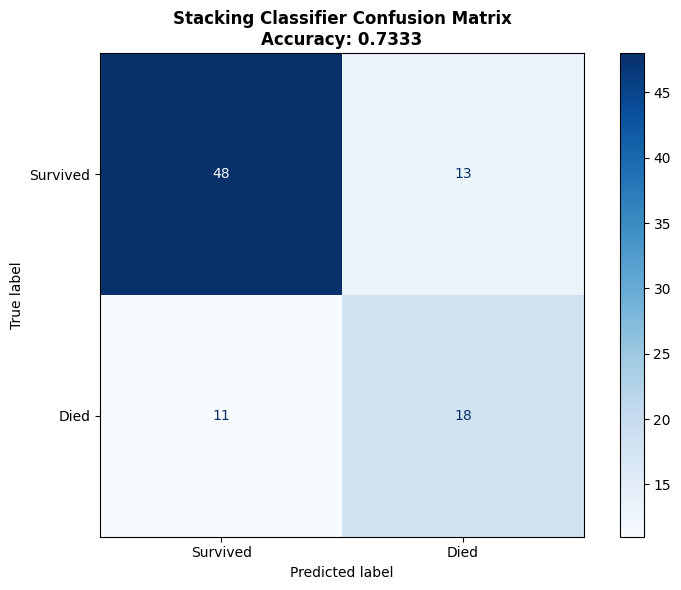

In [26]:
# Confusion matrix for stacking model
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_estimator(stacking, X_test_s, y_test, ax=ax, 
                                       cmap='Blues', values_format='d',
                                       display_labels=['Survived', 'Died'])

ax.set_title(f'Stacking Classifier Confusion Matrix\nAccuracy: {stacking_result["Accuracy"]:.4f}', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Section 9: Kaggle Challenge

### Challenge: Beat the Stacking Baseline

**Objective:** Achieve the highest **MCC score** on the test set (following the paper's ranking metric)

**Rules:**
1. Use `random_state=21` for all splits and models (ensures fair comparison)
2. Same data split: `train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)`
3. Same scaler: `StandardScaler()` fitted on training data
4. Max 100 Optuna trials for hyperparameter tuning
5. Final submission: Model name + MCC score

**Baseline to beat:**
- Stacking MCC: **{:.4f}**

**Hints:**
- Try `ExtraTreesClassifier` (a variant of Random Forest)
- Use `passthrough=True` in StackingClassifier to include raw features alongside base learner predictions
- Experiment with different combinations of base learners
- Use `voting='soft'` for VotingClassifier (probabilities)
- Consider ensemble of ensembles (meta-learning)

**Ranking:**
- 🥇 Highest MCC
- 🥈 Second highest
- 🥉 Third highest

Good luck!
""".format(stacking_result['MCC'])

In [27]:
# ============================================================================
# KAGGLE CHALLENGE - Your code goes here
# ============================================================================
# Instructions:
# 1. Load and preprocess data with random_state=21 (do NOT change this)
# 2. Build your best ensemble model
# 3. Report: model_name, Accuracy, F1, ROC-AUC, MCC
# 4. Example template below:
#
# from sklearn.ensemble import ExtraTreesClassifier
# 
# my_model = ExtraTreesClassifier(n_estimators=100, ...)
# my_model.fit(X_train_s, y_train)
# 
# my_result = evaluate_model('My Amazing Ensemble', my_model, X_train_s, y_train, X_test_s, y_test)
# print(my_result)
# ============================================================================


## Section 10: Summary & Resources

### Full Ensemble Comparison

| Method | Core Idea | Reduces | Speed | Overfitting | Sklearn Class | Modern Variant |
|--------|-----------|---------|-------|-------------|---------------|----------------|
| **Bagging** | Train parallel independent models on bootstrap samples | Variance | Fast | Low | `BaggingClassifier` | Random Forest |
| **Boosting** | Train sequential models to correct previous errors | Bias & Variance | Slow | Medium (can overfit) | `AdaBoost`, `GradientBoosting` | XGBoost, LightGBM |
| **Voting** | Aggregate predictions from diverse base learners | Both | Fast | Low | `VotingClassifier` | Weighted averaging |
| **Stacking** | Train meta-learner on base learner predictions | Both | Medium | Low (with CV) | `StackingClassifier` | Neural network meta-learner |

### When to Use What

**Use Bagging/Random Forest:**
- Fast training needed
- Parallel processing available
- Want easy interpretability (feature importance)

**Use Boosting (XGBoost/LightGBM):**
- Maximum accuracy required
- Have time for careful hyperparameter tuning
- Imbalanced or complex dataset

**Use Voting:**
- Want diversity of different algorithm types
- Computational budget low
- No access to probabilities (use hard voting)

**Use Stacking:**
- Already have tuned individual models
- Want to squeeze final 1-2% performance
- Have enough data for meta-learner training

### Connection to Chicco & Jurman (2020)

The paper emphasizes:
- **MCC is the most balanced metric** for binary classification with imbalanced data
- **No single metric is sufficient** — always report multiple metrics
- **Ensemble methods outperform single models** — use them for critical applications
- **Cross-validation is essential** for honest performance estimates

Our stacking implementation follows best practices:
✅ Out-of-fold predictions to avoid data leakage
✅ Diverse base learners (tree-based + linear)
✅ Simple meta-learner (logistic regression)
✅ Evaluation on multiple metrics
✅ Final model trained on full training data

### Resources

**Ensemble Methods:**
- [StatQuest: Bagging and Random Forests](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ)
- [StatQuest: Gradient Boost](https://www.youtube.com/watch?v=3CC4N_yofrA)
- [StatQuest: XGBoost in Depth](https://www.youtube.com/playlist?list=PLblh5JKOoLULnKaL8c4up0HAyABB8GkqR)

**LightGBM:**
- [LightGBM Official Documentation](https://lightgbm.readthedocs.io/)
- [Parameter Tuning Guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

**Stacking:**
- [Sklearn StackingClassifier](https://scikit-learn.org/stable/modules/ensemble.html#stacking)
- [Stacked Generalization (Wolpert 1992)](https://www.semanticscholar.org/paper/Stacked-generalization-Wolpert/12d7e7a5b54a1fa6b3fea3f9b68eed2e1fffdcd9)

**Data Imbalance & Metrics:**
- [Chicco & Jurman (2020): The advantages of the Matthews correlation coefficient (MCC)](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)
- [Imbalanced-Learn Library](https://imbalanced-learn.org/)

**Hyperparameter Optimization:**
- [Optuna Documentation](https://optuna.readthedocs.io/)
- [Hyperparameter Optimization (Hyperopt vs Optuna vs Ray Tune)](https://www.youtube.com/watch?v=Gbl_Sm7XmVQ)